## Entwicklung eines RL-Agent

Ziel dieses Notebooks ist es, das Mountain Car-Szenario aus der OpenAI Gym-Umgebung zu trainieren (https://gymnasium.farama.org/environments/classic_control/mountain_car/), sodass das Auto mithilfe von Reinforcement Learning die Flagge auf dem Hügel erreicht. Zusätzlich soll der Agent so schnell wie möglich und so nah wie möglich an die Flaggenposition von 0,5 gelangen. Die Umgebung hat folgende Eigenschaften:

1) Aktionsraum: 0- nach links beschleunigen, 1 - nicht beschleunigen, 2 - nach rechts beschleunigen
2) Belohnung: -1 für jeden Zeitschritt, den das Auto benötigt, um den Gipfel zu erreichen
3) Startzustand: Position zwischen -0.6 und -0.4 mit einer Beschleunugung von 0
4) Ende der Episode: Das Auto erreicht eine Position ≥ 0.5 (Ziel erreicht) oder die maximale Episodenlänge von 200 Schritten wird überschritten

Es werden zwei unterschiedliche Ansätze aus dem Bereich des Reinforcement Learnings verwendet. Einmal den Actor-Critic Algorithmus und als zweites das Deep Q-Learning. 

### Imports

In [10]:
import gymnasium as gym
from collections import deque
from matplotlib import pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

### Actor-Critic Algorithmus

Beim Actor-Critic Algorithmus wird der Agent sowohl mit einer Policy als auch mit einer Value Funktion trainiert. Der Actor (Policy) lernt, wie man die Entscheidung trifft daher welche Aktion gewählt werden muss. Der Critic (Value Funktion) schaut wie gut die Entscheidung des Actors war. 

#### Konstanten

In [11]:
LEARNING_RATE_ACTOR = 0.0005
LEARNING_RATE_CRITIC = 0.001
GAMMA = 0.99
NUM_EPISODES = 500

#### Actor und Critic Modelle

In [12]:
class Actor(nn.Module):
    def __init__(self, state_shape, action_shape, hidden_size=64):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_shape, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_shape)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x


class Critic(nn.Module):
    def __init__(self, state_shape, hidden_size=64):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_shape, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        value = self.fc2(x)
        return value

#### Anpassung der Belohnungsfuntion

In [13]:
def calculate_reward(state, done):
    position = state[0].item()
    reward = -1.0
    if done:
        if position >= 0.5:
            reward = 100.0
        else:
            reward = -100.0

    reward += 10.0 * (position - (-0.5))

    return reward


#### Definition der Trainingsloop

In [14]:
def train_agent_batched(
    env,
    actor,
    critic,
    num_training_episodes,
    gamma,
    learning_rate_actor,
    learning_rate_critic,
):
    optimizer_actor = optim.Adam(actor.parameters(), lr=learning_rate_actor)
    optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)

    actor_losses, critic_losses, rewards_per_episode = [], [], []

    for episode in range(num_training_episodes):
        state, _ = env.reset()
        state = torch.FloatTensor(state)

        log_probs = []
        values = []
        rewards = []

        done = False
        ep_reward = 0

        while not done:
            probs = actor(state)
            dist = Categorical(probs)
            action = dist.sample()

            value = critic(state)

            next_state, reward, done, _, _ = env.step(action.item())
            reward = calculate_reward(next_state, done)

            log_probs.append(dist.log_prob(action))
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float32))

            state = torch.FloatTensor(next_state)
            ep_reward += reward


        returns = []
        discounted_return = 0
        for r in reversed(rewards):
            discounted_return = r + gamma * discounted_return
            returns.insert(0, discounted_return)

        returns = torch.tensor(returns)

        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        log_probs = torch.stack(log_probs)
        values = torch.cat(values)

        advantages = returns - values

        actor_loss = -(log_probs * advantages.detach()).mean()
        critic_loss = advantages.pow(
            2
        ).mean()

        optimizer_actor.zero_grad()
        actor_loss.backward()
        optimizer_actor.step()

        optimizer_critic.zero_grad()
        critic_loss.backward()
        optimizer_critic.step()

        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        rewards_per_episode.append(ep_reward)

        print(
            f"Episode {episode + 1}/{num_training_episodes} - Reward: {ep_reward:.2f}"
        )

    return actor_losses, critic_losses, rewards_per_episode, actor

####  Bester Agent

In [15]:
def run_best_agent(env, actor):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        env.render()
        state_tensor = torch.FloatTensor(state)
        with torch.no_grad():
            probs = actor(state_tensor)
        action = torch.argmax(probs).item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    print("Total reward:", total_reward)
    env.close()

#### Visualisierung der Ergebnisse

In [16]:
def plot_loss(actor_loss, critic_loss):
    plt.plot(actor_loss, label="Actor Loss")
    plt.plot(critic_loss, label="Critic Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Episode Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Episode Rewards")
    plt.grid(True)
    plt.show()

Episode 1/500 - Reward: -18675.32
Episode 2/500 - Reward: -2498.81
Episode 3/500 - Reward: -8697.50
Episode 4/500 - Reward: -10881.87
Episode 5/500 - Reward: -8778.10
Episode 6/500 - Reward: -6547.48
Episode 7/500 - Reward: -3265.58
Episode 8/500 - Reward: -4738.90
Episode 9/500 - Reward: -27361.17
Episode 10/500 - Reward: -9416.54
Episode 11/500 - Reward: -11834.21
Episode 12/500 - Reward: -2351.80
Episode 13/500 - Reward: -22837.60
Episode 14/500 - Reward: -5006.14
Episode 15/500 - Reward: -3810.67
Episode 16/500 - Reward: -6339.75
Episode 17/500 - Reward: -3438.86
Episode 18/500 - Reward: -15896.72
Episode 19/500 - Reward: -5022.89
Episode 20/500 - Reward: -23008.48
Episode 21/500 - Reward: -1472.07
Episode 22/500 - Reward: -3732.79
Episode 23/500 - Reward: -9034.34
Episode 24/500 - Reward: -4615.93
Episode 25/500 - Reward: -1883.82
Episode 26/500 - Reward: -1163.33
Episode 27/500 - Reward: -5139.91
Episode 28/500 - Reward: -2055.56
Episode 29/500 - Reward: -5698.92
Episode 30/500 -

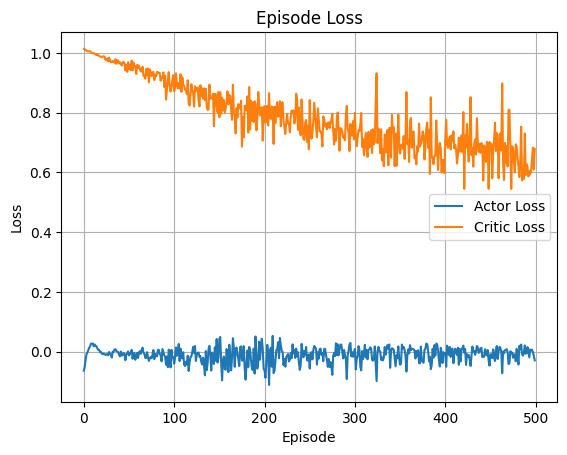

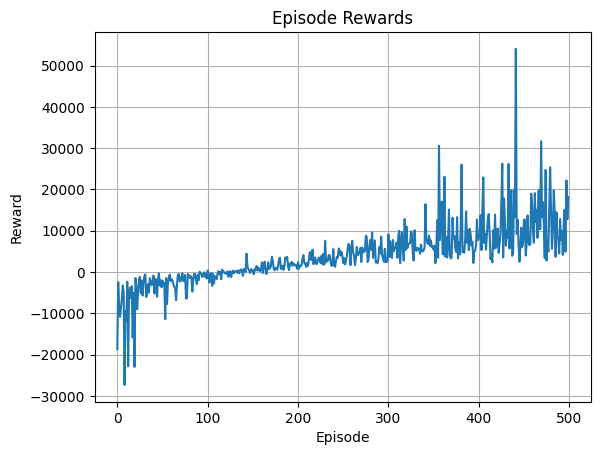

Total reward: -1000.0


In [18]:
env = gym.make("MountainCar-v0", max_episode_steps=1000)
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

actor = Actor(state_shape, action_shape)
critic = Critic(state_shape)

actor_loss, critic_loss, rewards, trained_actor = train_agent_batched(
    env=env,
    actor=actor,
    critic=critic,
    num_training_episodes=NUM_EPISODES,
    gamma=GAMMA,
    learning_rate_actor=LEARNING_RATE_ACTOR,
    learning_rate_critic=LEARNING_RATE_CRITIC,
)

plot_loss(actor_loss, critic_loss)
plot_rewards(rewards)

env = gym.make("MountainCar-v0", render_mode="human", max_episode_steps=1000)
run_best_agent(env, trained_actor)

### Deep Q-Learning

Q-Learning ist ein Algorithmus, der die beste Abfolge von Aktionen basierend auf dem aktuellen Zustand des Agenten ermittelt. Der Ablauf besteht aus insgesamt 6 Schritten:

1) Q-Funktion, die den Agenten aktualisiert
2) Belohnungs- bzw. Strafbewertung
3) Menge der möglichen Aktionen
4) Bevorzugte Aktion (die als optimal gilt)
5) Umgebung
6) Beobachtung

Insgesamt gibt es zwei Methoden, um Q-Learning anzuwenden. Zum einen das klassische, manuelle Q-Learning und zum anderen das Deep Q-Learning unter Verwendung neuronaler Netze. In diesem Notebook wird nur das Deep-Q-Learning umgesetzt. 

#### Konstanten 

In [12]:
LEARNING_RATE_DQN = 0.001
GAMMA_DQN = 0.99
EPSILON_MAX_DQN = 1.0
EPSILON_MIN_DQN = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
TARGET_UPDATE_FREQUENCY = 1000
MEMORY_SIZE = 10000
EPISODES = 1000

#### Target Network 

Dieses neuronale Netzwerk wird später dafür verwendet, um die Q-Werte zu berechnen.

In [13]:
class DQN(nn.Module):
    def __init__(self, space_dimension, num_actions, output_features=24):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(space_dimension, output_features)
        self.fc2 = nn.Linear(output_features, output_features)
        self.fc3 = nn.Linear(output_features, num_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### DQN Agent

In dieser Klasse wird das DQN Modell von oben verwendet, um den Agenten zu trainieren. Dafür wird die Epsilon-Greedy Strategien, die Bellman Funktion verwendet und die Erfahrungen in einem Replay-Buffer gespeichert. 

In [14]:
class DQNAgent:
    def __init__(
        self,
        env,
        learning_rate,
        gamma,
        epsilon_max,
        epsilon_min,
        epsilon_decay,
        memory_size,
        batch_size,
    ):
        self.env = env
        self.epsilon = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.state_dimension = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n

        self.memory = deque(maxlen=memory_size)

        self.target_model = DQN(self.state_dimension, self.num_actions)
        self.target_model.load_state_dict(self.target_model.state_dict())
        self.target_model.eval()
        self.optimizer = optim.Adam(self.target_model.parameters(), lr=learning_rate)

        self.batch_size = batch_size

        self.losses_per_episode = []
        self._current_episode_loss = 0.0
        self._loss_steps = 0

    def state_to_tensor(self, state):
        if isinstance(state, torch.Tensor):
            return state.float()
        else:
            return torch.from_numpy(
                np.reshape(state, [1, self.env.observation_space.shape[0]])
            ).float()

    def add_to_memory(self, state, action, reward, next_state, done):
        if isinstance(state, torch.Tensor):
            state = state.numpy().flatten()
        if isinstance(next_state, torch.Tensor):
            next_state = next_state.numpy().flatten()
        self.memory.append((state, action, reward, next_state, done))

    def epsilon_greedy_strategy(self, state):
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > self.epsilon:
            state_tensor = self.state_to_tensor(state)
            q_values = self.target_model(state_tensor)
            action = torch.argmax(q_values).item()
        else:
            action = self.env.action_space.sample()

        return action

    def epsilon_update(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)
        return self.epsilon

    def replay_memory(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states = torch.cat([self.state_to_tensor(s) for s, _, _, _, _ in minibatch])
        actions = torch.tensor([a for _, a, _, _, _ in minibatch])
        rewards = torch.tensor([r for _, _, r, _, _ in minibatch])
        next_states = torch.cat(
            [self.state_to_tensor(ns) for _, _, _, ns, _ in minibatch]
        )
        dones = torch.tensor([d for _, _, _, _, d in minibatch], dtype=torch.float)

        q_values = self.target_model(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

        with torch.no_grad():
            max_next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + self.gamma * max_next_q * (1 - dones)

        loss = nn.MSELoss()(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self._current_episode_loss += loss.item()
        self._loss_steps += 1

    def finalize_episode(self):
        if self._loss_steps > 0:
            avg_loss = self._current_episode_loss / self._loss_steps
        else:
            avg_loss = 0.0
        self.losses_per_episode.append(avg_loss)
        self._current_episode_loss = 0.0
        self._loss_steps = 0

#### Training des DQN-Agenten 

Mit dieser Funktion kann der Agent über eine bestimmte Anzahl von Episoden, hier 1000, trainiert werden. Eine Episode dauert so lange bis der Agent, hier unser Mountain Car, das Ziel erreicht hat.

In [15]:
def train(
    env,
    episodes,
    learning_rate,
    gamma,
    epsilon_max,
    epsilon_min,
    epsilon_decay,
    memory_size,
    batch_size,
):
    rewards_per_episode = []
    episode_lengths = []
    dqn = DQNAgent(
        env,
        learning_rate,
        gamma,
        epsilon_max,
        epsilon_min,
        epsilon_decay,
        memory_size,
        batch_size,
    )
    for episode in range(episodes):

        print(f"Episode: {episode} ======================================")

        state = env.reset()[0]
        state = dqn.state_to_tensor(state)
        done = False
        steps = 0
        curr_reward = 0

        while done == False:
            steps += 1
            action = dqn.epsilon_greedy_strategy(state)
            new_state, reward, new_done, _, _ = env.step(action)
            new_state = dqn.state_to_tensor(new_state)
            if new_state[0][0] >= 0.5:
                reward += 100
            dqn.add_to_memory(state, action, reward, new_state, new_done)
            state = new_state
            done = new_done
            curr_reward += reward
            if done:
                break
            dqn.replay_memory()

        rewards_per_episode.append(curr_reward)
        episode_lengths.append(steps)
        dqn.finalize_episode()
        dqn.epsilon_update()


    env.close()
    return rewards_per_episode, episode_lengths, dqn

#### Bester Agent

Diese Funktion ist dafür da den besten Agent in der Umgebung einmal visuell zu zeigen. Dies macht man in dem man dem env sagt, dass man den render mode "human" haben möchte. Für das Training wurde dieser mode nicht verwendet, da es das Training deutlich verlangsamt. 

In [19]:
def run_best(agent):
    env = gym.make("MountainCar-v0", render_mode="human")
    state = env.reset()[0]
    state = agent.state_to_tensor(state)
    done = False
    total_reward = 0
    steps = 0

    positions = []

    while not done:
        with torch.no_grad():
            q_values = agent.target_model(state)
            action = torch.argmax(q_values).item()

        next_state, reward, done, _, _ = env.step(action)
        positions.append(next_state[0])
        next_state = agent.state_to_tensor(next_state)

        state = next_state
        total_reward += reward
        steps += 1

    print(
        f"Best Run: Reward = {total_reward:.2f}, Steps = {steps}, End Position = {state[0][0]}"
    )
    env.close()

    return positions

#### Visualisierung der Ergebnisse

In [16]:
def plot_train_progress_length(episode_lengths):
    plt.plot(episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Steps to goal")
    plt.title("Training Progress")
    plt.grid(True)
    plt.show()

In [17]:
def plot_train_progress_rewards(rewards_per_episode):
    plt.plot(rewards_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Reward Progress over Time of Mountain Car")
    plt.grid(True)
    plt.show()

In [18]:
def plot_loss(agent):
    plt.figure(figsize=(10, 6))
    plt.plot(agent.losses_per_episode, label="Average Loss per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("DQN Training Loss Per Episode")
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
def plot_positions(positions):
    plt.plot(positions)
    plt.axhline(y=0.5, color="r", linestyle="--", label="Goal Position (0.5)")
    plt.xlabel("Step")
    plt.ylabel("Position")
    plt.title("Best Episode: Position Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

DISCLAIMER: The kernel crashed nachdem der beste Agent visuell gezeigt wurde, da sich pygame nicht von alleine schließt und das Schließen forciert werden muss. Dies passiert aber erst nachdem schon das Training des Agenten erfolgreich abgeschlossen wurde.

Episode: 0 ======================================
Episode: 1 ======================================
Episode: 2 ======================================
Episode: 3 ======================================
Episode: 4 ======================================
Episode: 5 ======================================
Episode: 6 ======================================
Episode: 7 ======================================
Episode: 8 ======================================
Episode: 9 ======================================
Episode: 10 ======================================
Episode: 11 ======================================
Episode: 12 ======================================
Episode: 13 ======================================
Episode: 14 ======================================
Episode: 15 ======================================
Episode: 16 ======================================
Episode: 17 ======================================
Episode: 18 ======================================
Episode: 19 =============================

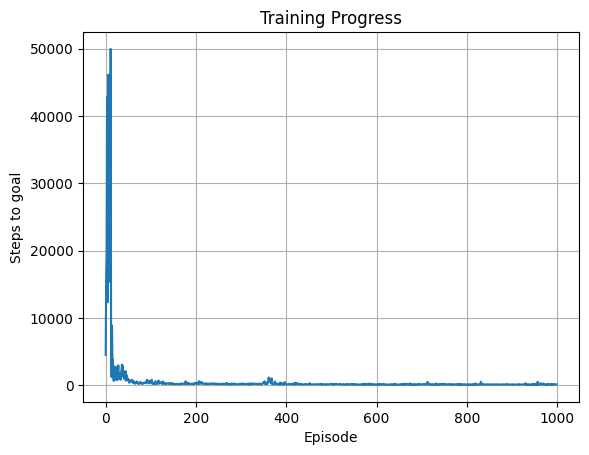

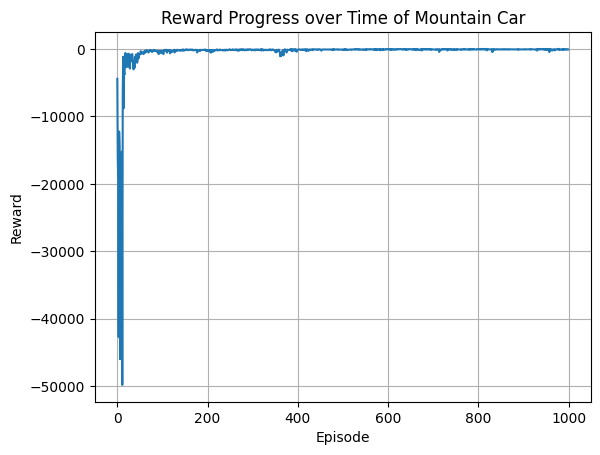

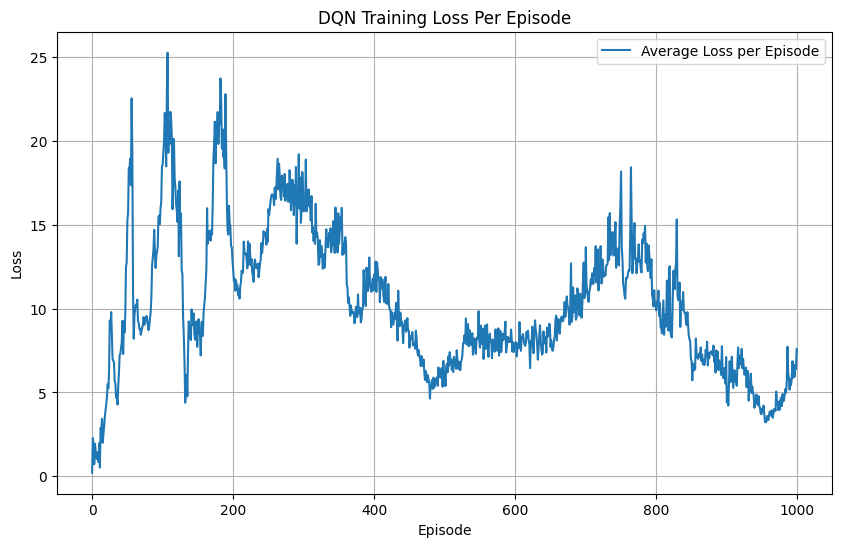

Best Run: Reward = -148.00, Steps = 148, End Position = 0.5135239362716675


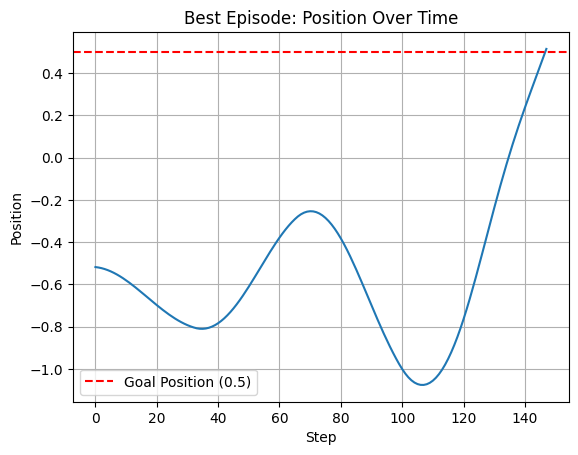

: 

In [21]:
env = gym.make("MountainCar-v0")
rewards, episode_lengths, trained_agent = train(
    env,
    episodes=EPISODES,
    learning_rate=LEARNING_RATE_DQN,
    gamma=GAMMA_DQN,
    epsilon_max=EPSILON_MAX_DQN,
    epsilon_min=EPSILON_MIN_DQN,
    epsilon_decay=EPSILON_DECAY,
    memory_size=MEMORY_SIZE,
    batch_size=BATCH_SIZE,
)
plot_train_progress_length(episode_lengths=episode_lengths)
plot_train_progress_rewards(rewards_per_episode=rewards)
plot_loss(trained_agent)
positions = run_best(trained_agent)
plot_positions(positions)